<a href="https://colab.research.google.com/github/KukovecRok/AlexNet_inefficient_using_NiaPy/blob/main/AlexNetDiplomskaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predpogoj - mount gDrive

In [1]:
# Nujno potrebno za dostop do datotek iz gDrivea
from google.colab import drive
drive.mount('/content/gdrive') # Preverjanje pristnosti.. 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Potrebni importi
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import argparse
import PIL.Image
import pandas as pd
import glob
from pathlib import Path
import time
from numpy import asarray

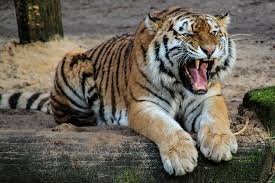

In [3]:
from IPython.display import Image, display
display(Image('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')) # Slika iz https://phys.org/news/2019-11-indian-authorities-exaggerated-tiger.html

## Prikaz random slike iz množice

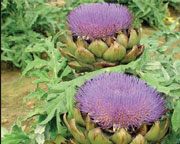

In [4]:
import random, os
# Prikaz nakljucne slike
path = "/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/"
random_file = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
Image('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+random_file)

## Funkcija napovejSlike

In [5]:
def napovejSlike(slika, alexnet):
   # Obdelava velikosti slike
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),       # Nastavi velikost sičic 224x224
        transforms.ToTensor(),              # Input na Tensorjev format
        transforms.Normalize( # Normalizacija
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])
    # Odpiranje slik
    transformed_img = data_transforms(slika) # Klicanje funkcije za obdelavo velikosti slik(e)
    batch_img = torch.unsqueeze(transformed_img, 0)
    
    output = alexnet(batch_img)

    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0 
    
    return indices, percentage

In [6]:
# Izboljsana napoved - vse slike v mapi
CasZacetek = time.time()

alexnet = models.alexnet(pretrained=True)
alexnet.eval()

df = None
if df is not None:
    df = df.drop(['SlicicaNo.','Dejansko','Napovedano','PoNiaPy','Tocnost'], axis=1, errors='ignore')

#images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/*.jpg")
images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/*.JPEG")
podatki = []
for image in images:
   with open(image, 'rb') as file:
        img = PIL.Image.open(file)
        indices, percentage = napovejSlike(img, alexnet)
        i = 0
        with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]

            podatki.append({
                'Slicica No.': (Path(file.name).stem)[20:],
                'Napovedano':  results[0][0],
                'PoNiaPy' : ['Sledi'],
                'Tocnost' : results[0][1],
                'ImeDatoteke' : (Path(file.name).stem + ".JPEG")
            })

            print("\nTop 5 napovedanih razredov")
            for i in range(5):
                print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

df = pd.DataFrame(data=podatki)
df.sort_values(by='Tocnost', ascending=False, inplace=True)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
trajanje
# Merjenje časa - CPU 71 sekund ; GPU 301; TPU 338 - nekaj ni ok..

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Izpis pretočnega predvajanja je skrajšan na toliko zadnjih vrstic: 5000.

Top 5 napovedanih razredov
barometer: 42.3117%
scale, weighing machine: 41.4288%
analog clock: 10.6591%
wall clock: 1.4379%
toilet seat: 0.8245%

Naš napovedan razred: barometer 
Algoritem to trdi z zagotovostvjo 42.31%

Top 5 napovedanih razredov
buckeye, horse chestnut, conker: 11.4822%
cabbage butterfly: 10.3432%
bee: 8.9356%
daisy: 7.9434%
cardoon: 3.9701%

Naš napovedan razred: buckeye, horse chestnut, conker 
Algoritem to trdi z zagotovostvjo 11.48%

Top 5 napovedanih razredov
abacus: 76.8256%
crib, cot: 19.4869%
cradle: 1.0485%
shopping basket: 0.6149%
plate rack: 0.2065%

Naš napovedan razred: abacus 
Algoritem to trdi z zagotovostvjo 76.83%

Top 5 napovedanih razredov
space heater: 29.4209%
measuring cup: 7.1921%
crib, cot: 5.4482%
shopping basket: 5.3668%
shower curtain: 4.1525%

Naš napovedan razred: space heater 
Algoritem to trdi z zagotovostvjo 29.42%

Top 5 napovedanih razredov
bee: 64.1731%
sea an

358.5188434123993

## Slike iz ILSVRC2010
Model se je na njih izkazal za zelo uspešnega

Tukaj imamo tabelo imen datotek ter kategorij, v katero spadajo

In [7]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/ID,Ime,Kategorija.csv", sep=";", index_col=0) 
df1.sample(5) 

,ImeDatoteke,Kategorija
ID_Kategorija,,
76,ILSVRC2010_val_00009377.JPEG,coral reef
533,ILSVRC2010_val_00004239.JPEG,"mouse, computer mouse"
772,ILSVRC2010_val_00027329.JPEG,"lipstick, lip rouge"
869,ILSVRC2010_val_00015882.JPEG,"dam, dike, dyke"
977,ILSVRC2010_val_00027474.JPEG,scabbard


## Skupne kategorije
* 634
* Kategorije v preseku, ki jih zna napovedatovat tale AlexNet in slike iz ILSVRC2010
* Validacijska množica ni uporabljena za učenje, rezultati bodo verjetno višji kot pri testni, kar je v mojem primeru tudi smiselno
* Velika točnost pred NiaPy, nato pa nekaj popolnoma drugega za "enako" sliko..

In [8]:
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/BothKategorije.csv", sep=";", index_col=0) 
print(len(df2))
#df2.head(10)

634


## Predpripravljena tabela 
* stolpec NiaPy se bo napolnil kasneje

In [9]:
# Združevanje za dejanske kategorije
df = df.merge(df1, how='inner', on='ImeDatoteke')
# Brisanje praznih (v df1 je 50.000 vrstic - celotna _val množica slik)
df.dropna(inplace=True)
# Združevanje iz dataframera samo skupnih kategorij --> Inner join odstrani vse primerke, ki jih naš model ne zna napovedat
df = df.merge(df2, how='inner', on='Kategorija')
# Preimenovanje stolpca
df = df.rename(columns={"Kategorija": "Dejanska_kategorija"})
# Zamenjava vrstnega reda stolpcev
df = df[['Slicica No.','Dejanska_kategorija','Napovedano','PoNiaPy','Tocnost','ImeDatoteke']]
df.sort_values(by=['Tocnost'], ascending=False).head(10)
# Dolžina df = 636, kar se sklada s številom različnih imen datotek, katerih kategorije zna napovedat
# V driveu je 1000 slik, vseh kategorij je ~1600, naš AlexNet jih zna napovedat ~2/3 = 1000. 
# Slike so randomly vendar konsistentno poimenovane, ~2/3 * 1000 = ~ 640, torej bo najverjetneje držalo

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


In [10]:
col_one_list = df['ImeDatoteke'].tolist()
col_one_list.sort()
# Število različnih imen datotek = 637 - Nekatere kategorije so podvojene (različne slike spadajo v enako kategorijo)
len(col_one_list)

637

## Tabela napačno napovedanih

In [11]:
dfNapacni = df[~df['Dejanska_kategorija'].isin(df['Napovedano'])]
dfNapacni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
262,977,otter,badger,[Sledi],90.782722,ILSVRC2010_val_00000977.JPEG
300,855,"bakery, bakeshop, bakehouse",trifle,[Sledi],87.583473,ILSVRC2010_val_00000855.JPEG
305,415,trimaran,catamaran,[Sledi],86.632591,ILSVRC2010_val_00000415.JPEG
312,193,screwdriver,nail,[Sledi],85.336327,ILSVRC2010_val_00000193.JPEG
329,704,"green lizard, Lacerta viridis","American chameleon, anole, Anolis carolinensis",[Sledi],82.166130,ILSVRC2010_val_00000704.JPEG
337,155,partridge,"ruffed grouse, partridge, Bonasa umbellus",[Sledi],79.790657,ILSVRC2010_val_00000155.JPEG
343,344,cliff dwelling,"sloth bear, Melursus ursinus, Ursus ursinus",[Sledi],78.339386,ILSVRC2010_val_00000344.JPEG
397,353,"artichoke, globe artichoke",cardoon,[Sledi],70.422081,ILSVRC2010_val_00000353.JPEG
416,975,tiger cat,"tiger, Panthera tigris",[Sledi],65.720955,ILSVRC2010_val_00000975.JPEG
263,728,otter,"red-backed sandpiper, dunlin, Erolia alpina",[Sledi],65.469406,ILSVRC2010_val_00000728.JPEG


## Tabela pravilno napovedanih

In [12]:
dfPravilni = df[df['Dejanska_kategorija'].isin(df['Napovedano'])] #dfPravilni = df.loc[df['Dejanska_kategorija'] == df['Napovedano']] # Drugačna sintaksa za isto stvar
dfPravilni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


## Statistika nad ILSVRC2010_val_\*\*\*\*****.JPEG

In [13]:
pravilno_napovedani = len(df.index) - len(dfNapacni.index)
print("Vsi napovedani: " + str(len(df.index)) + "\nPravilno napovedani: " + str(pravilno_napovedani) +"\nNapacno napovedani: " + str(len(dfNapacni.index)))
Tocnost = (pravilno_napovedani / len(df.index)* 100)
print("Tocnost: %.4f"% Tocnost+"%")

Vsi napovedani: 637
Pravilno napovedani: 535
Napacno napovedani: 102
Tocnost: 83.9874%


In [14]:
# Napoved 1 slike
slika = 'ILSVRC2010_val_00000857.JPEG'
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: baseball 
Algoritem to trdi z zagotovostvjo 100.00%


In [15]:
!pip install NiaPy==2.0.0rc12

# NiaPy 
Prva ideja je po vzoru TestBenchmark.py, ustvarit array podoben "iskanje = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]"
* Pretvorba slike v 1d array
* Standardizacija (vsaka vrednost v arrayu / 255)
* Izvajanje NiaPy
* Pretvorba napovedanih vredenosti nazaj v vrednosti med 1 - 255 ( * 255)
* Pretvorba 1d arraya v sliko
* Prikaz slike, primerjava..
### Prihaja do napake pri pretvorbi ( i / 255 ; i * 255 ) 
* Sumim .reshape ( np.asarray(flat_arr).reshape(prvotenShape) )

Image Dimensions : (145, 145, 3)
1d array:  [247 247 247 ... 252 252 252]
testko po deljenju:  [0.9686274509803922, 0.9686274509803922, 0.9686274509803922, 0.9647058823529412, 0.9647058823529412, 0.9647058823529412, 0.9803921568627451, 0.9803921568627451, 0.9803921568627451, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.984313725490196, 0.984313725490196, 0.984313725490196, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9921568627450981, 0.9921568627450981, 0.9921568627450981, 0.9803921568627451, 0.9803921568627451, 0.9803921568627451, 1.0, 0.9921568627450981, 0.9921568627450981, 1.0, 0.9921568627450981, 0.9921568627450981, 1.0, 0.996078431372549, 0.99607843137254

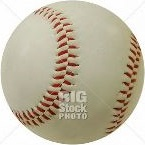

In [73]:
# Drugačna metoda slika --> 1d

import cv2
from google.colab.patches import cv2_imshow

def imgTO1d(img):
    oblika = img.shape
    img = img.reshape(-1)
    testko = [i / 255 for i in img] # Shrani prvoten shape slike
    return oblika, testko

def imgFROM1d(testko, oblika):
    testkoDva = [int(i * 255) for i in testko]
    testkoDva = asarray(testkoDva)
    print("Type of testkoDva: " , type(testkoDva))
    #oblika = (145, 145, 3)
    testkoDva = testkoDva.reshape(oblika)
    return testkoDva

#read image
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG')
oblika, testko = imgTO1d(img)
#print its shape
print('Image Dimensions :', img.shape)

img = img.reshape(-1)
#print("1d array: ")
print("1d array: ", img)

testko = [i / 255 for i in img]
print("testko po deljenju: " ,testko)

testkoDva = [int(i * 255) for i in testko]
print("testkoDva po množenju: " , testkoDva)

testkoDva = asarray(testkoDva)
print("Type of testkoDva: " , type(testkoDva))
testkoDva = testkoDva.reshape(145,145,3)
#print("testkoDva reshapean nazaj v prvotno obliko: " , testkoDva)

cv2_imshow(testkoDva)

## Trenutna slika
* samo 1
* bejzbol.jpeg ( original : "ILSVRC2010_val_00000857.JPEG" )
* pomanjašana v 160x160
* testiranje delovanja pretvorbe in NiaPy

In [17]:
# Napoved 1 slike
#slika = 'ILSVRC2010_val_00000857.JPEG'
slika = 'bejzbol.JPEG'
#with open('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+slika, 'rb') as file:
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: baseball 
Algoritem to trdi z zagotovostvjo 100.00%


In [74]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0
            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

            return razlika

        return evaluate

if __name__ == "__main__":

    #originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/ILSVRC2010_val_00000857.JPEG')
    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')
    #originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG')


    oblika, iskanjeSlika = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=20)  

    n = len(iskanjeSlika)
    rangeFor = (int(n / 3))
    #n = 63075
    
    test = np.empty(n, dtype=object)
    iskanje = np.empty(3, dtype=object)
    
    for i in range(rangeFor):
        i *= 3
        #print(i, i+1, i+2)
        iskanje[0] = iskanjeSlika[i]
        iskanje[1] = iskanjeSlika[i+1]
        iskanje[2] = iskanjeSlika[i+2]
    
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                            nFES=20,
                            optType=OptimizationType.MINIMIZATION,
                            benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)
        test[i] = resitev[0]
        test[i+1] = resitev[1]
        test[i+2] = resitev[2]

    print("ISKANJE: ", iskanje)
    print("resitev: ", resitev)
    print("fitness: ", fitness)
    # 10.000 in 100.000 "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. "

ISKANJE:  [0.2901960784313726 0.4627450980392157 0.30980392156862746]
resitev:  [0.1350558  0.4331878  0.26523445]
fitness:  0.2292670475192326


150975 150975
Type of testkoDva:  <class 'numpy.ndarray'>


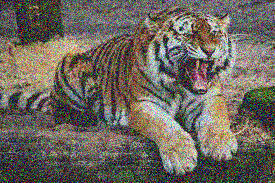

In [75]:
print(len(iskanjeSlika), len(test))
poskusDva = imgFROM1d(test, oblika)
#print(poskusDva.tolist()) 
cv2_imshow(poskusDva)

In [76]:
PIL_image = Image.fromarray(np.uint8(poskusDva)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    # Top 5 razredov po verjetnosti napovedi
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: tiger cat 
Algoritem to trdi z zagotovostvjo 39.63%


In [72]:
poskusDva.shape

(145, 145, 3)